In [1]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
)
from datasets import load_dataset
import numpy as np
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    hamming_loss
)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import html
import random
import re

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Also set Python hash seed
    import os
    os.environ['PYTHONHASHSEED'] = str(seed)

# CALL THIS IMMEDIATELY
set_seed(123)

warnings.filterwarnings('ignore')

# NLTK imports with fallback
try:
    import nltk
    from nltk.corpus import wordnet as wn
    from nltk.tokenize import word_tokenize

    # Download required NLTK data
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        nltk.download('punkt', quiet=True)
    try:
        nltk.data.find('corpora/wordnet')
    except LookupError:
        nltk.download('wordnet', quiet=True)
    try:
        nltk.data.find('taggers/averaged_perceptron_tagger')
    except LookupError:
        nltk.download('averaged_perceptron_tagger', quiet=True)

    NLTK_AVAILABLE = True
except ImportError:
    print("Warning: NLTK not available. Using simpler augmentation methods.")
    NLTK_AVAILABLE = False
    # Fallback tokenization
    def word_tokenize(text):
        return text.split()

In [2]:
class Config:
    # Model settings
    MODEL_NAME = 'roberta-base'
    MAX_LENGTH = 200
    NUM_LABELS = 28

    # Training settings - Optimized based on SOTA results
    BATCH_SIZE = 32
    LEARNING_RATE = 0.00001
    NUM_EPOCHS = 5
    WARMUP_RATIO = 0.1
    WEIGHT_DECAY = 0.05
    MAX_GRAD_NORM = 1.0
    EARLY_STOPPING = 2
    USE_COSINE_SCHEDULER = False

    # Loss function settings - Tuned for better performance
    USE_FOCAL_LOSS = False
    FOCAL_ALPHA = 0.3
    FOCAL_GAMMA = 2.0
    CLASS_WEIGHT_SMOOTHING = 'sqrt'
    LABEL_SMOOTHING = 0.1

    # Data augmentation settings - High-quality augmentation for minority classes
    USE_AUGMENTATION = True
    MINORITY_CLASS_AUGMENTATION = True
    MINORITY_THRESHOLD = 0.3
    AUGMENTATION_TARGET_MULTIPLIER = 2.0
    MAX_AUGMENTATIONS_PER_SAMPLE = 2

    COMBINE_AND_RESPLIT = False  # Combine train/val and resplit
    TRAIN_VAL_SPLIT_RATIO = 0.9

    # System settings
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Paths
    MODEL_SAVE_PATH = 'roberta_emotion_model'

    # Ekman emotion mapping settings
    USE_EKMAN_MAPPING = True
    EKMAN_NAMES = ['anger', 'fear', 'joy', 'sadness', 'surprise']

    # Emotion labels
    EMOTION_NAMES = [
        'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
        'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
        'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
        'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
        'relief', 'remorse', 'sadness', 'surprise', 'neutral'
    ]

    def __init__(self):
        self.NUM_LABELS = 5 if self.USE_EKMAN_MAPPING else 28

config = Config()
EKMAN_MAPPING = {
    'joy': ['admiration', 'amusement', 'approval', 'caring', 'desire', 'excitement', 'gratitude', 'joy', 'love', 'optimism', 'pride', 'relief'],
    'sadness': ['disappointment', 'grief', 'remorse', 'sadness'],
    'anger': ['anger', 'annoyance', 'disapproval'],
    'fear': ['fear', 'nervousness'],
    'surprise': ['confusion', 'curiosity', 'realization', 'surprise']
}
EKMAN_EXCLUDE = ['neutral', 'disgust', 'embarrassment']


def convert_to_ekman_labels(go_emotions_label_vector):
    exclude_indices = [config.EMOTION_NAMES.index(emotion) for emotion in EKMAN_EXCLUDE]
    if any(go_emotions_label_vector[idx] == 1 for idx in exclude_indices):
        return None  # Exclude this sample

    # Initialize Ekman label vector (5 emotions)
    ekman_labels = [0] * config.NUM_LABELS

    # Map each Go-Emotion to Ekman emotion
    for ekman_idx, ekman_emotion in enumerate(config.EKMAN_NAMES):
        if ekman_emotion in EKMAN_MAPPING:
            go_emotions_list = EKMAN_MAPPING[ekman_emotion]
            for go_emotion in go_emotions_list:
                if go_emotion in config.EMOTION_NAMES:
                    go_idx = config.EMOTION_NAMES.index(go_emotion)
                    if go_emotions_label_vector[go_idx] == 1:
                        ekman_labels[ekman_idx] = 1  # Set corresponding Ekman emotion

    return ekman_labels


def get_emotion_names():
    return config.EKMAN_NAMES if config.USE_EKMAN_MAPPING else config.EMOTION_NAMES


print("=" * 80)
print("RoBERTa Emotion Detection Training Pipeline")
print("=" * 80)

# Print mode indicator
if config.USE_EKMAN_MAPPING:
    print("Training with Ekman mapping")
else:
    print("Training with Go-Emotions")

print(f"\nDevice: {config.DEVICE}")
print(f"Model: {config.MODEL_NAME}")
print(f"Batch Size: {config.BATCH_SIZE}")
print(f"Learning Rate: {config.LEARNING_RATE}")
print(f"Epochs: {config.NUM_EPOCHS}")
print(f"Max Length: {config.MAX_LENGTH}")
print(f"Number of Labels: {config.NUM_LABELS}")

RoBERTa Emotion Detection Training Pipeline
Training with Ekman mapping

Device: cuda
Model: roberta-base
Batch Size: 32
Learning Rate: 1e-05
Epochs: 5
Max Length: 200
Number of Labels: 5


In [3]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(inputs)

        # Calculate BCE loss
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, pos_weight=self.pos_weight, reduction='none'
        )
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma

        # Apply alpha weighting
        if self.alpha is not None:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            focal_loss = alpha_t * focal_weight * bce_loss
        else:
            focal_loss = focal_weight * bce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [4]:
def get_synonyms(word, pos_tag=None):
    if not NLTK_AVAILABLE:
        return []

    synonyms = set()
    try:
        # Map POS tags to WordNet POS tags
        pos_map = {
            'NN': wn.NOUN, 'NNS': wn.NOUN, 'NNP': wn.NOUN, 'NNPS': wn.NOUN,
            'JJ': wn.ADJ, 'JJR': wn.ADJ, 'JJS': wn.ADJ,
            'VB': wn.VERB, 'VBD': wn.VERB, 'VBG': wn.VERB, 'VBN': wn.VERB, 'VBP': wn.VERB, 'VBZ': wn.VERB,
            'RB': wn.ADV, 'RBR': wn.ADV, 'RBS': wn.ADV
        }

        wordnet_pos = pos_map.get(pos_tag, None) if pos_tag else None

        for syn in wn.synsets(word, pos=wordnet_pos):
            for lemma in syn.lemmas():
                synonym = lemma.name().replace('_', ' ').lower()
                if synonym != word.lower() and len(synonym.split()) == 1:
                    synonyms.add(synonym)
    except:
        pass

    return list(synonyms)[:3]  # Return up to 3 synonyms


def smart_synonym_replacement(text, replacement_ratio=0.2):
    """Replace words with synonyms while preserving meaning"""
    if not NLTK_AVAILABLE:
        words = text.split()
        if len(words) > 1:
            # Try word swap first
            idx1, idx2 = random.sample(range(len(words)), 2)
            words[idx1], words[idx2] = words[idx2], words[idx1]
            result = ' '.join(words)
            if result != text:
                return result
            # If swap didn't change anything (same words), try capitalization
            if len(words) > 0:
                words[0] = words[0].capitalize() if words[0].islower() else words[0].lower()
                return ' '.join(words)
        return text

    try:
        words = word_tokenize(text)
        if len(words) < 3:
            return text

        # Get POS tags for better synonym matching
        pos_tags = nltk.pos_tag(words)

        # Select words to replace (avoid stop words and punctuation)
        stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'}
        replaceable_indices = [i for i, (word, pos) in enumerate(pos_tags)
                              if word.lower() not in stop_words and word.isalnum()]

        if len(replaceable_indices) == 0:
            return text

        num_replacements = max(1, int(len(replaceable_indices) * replacement_ratio))
        indices_to_replace = random.sample(replaceable_indices, min(num_replacements, len(replaceable_indices)))

        new_words = words.copy()
        for idx in indices_to_replace:
            word, pos_tag = pos_tags[idx]
            synonyms = get_synonyms(word.lower(), pos_tag)
            if synonyms:
                new_words[idx] = random.choice(synonyms)

        return ' '.join(new_words)
    except:
        return text


def smart_word_deletion(text, deletion_ratio=0.15):
    """Delete non-essential words while preserving core meaning"""
    try:
        words = word_tokenize(text)
        if len(words) < 4:
            return text

        # Identify less important words (determiners, some adverbs, etc.)
        if not NLTK_AVAILABLE:
            stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'}
            deletable_indices = [i for i, word in enumerate(words) if word.lower() in stop_words]
            if deletable_indices:
                idx = random.choice(deletable_indices)
                words.pop(idx)
            return ' '.join(words)

        pos_tags = nltk.pos_tag(words)
        less_important_tags = {'DT', 'IN', 'CC', 'RB'}  # Determiners, prepositions, conjunctions, some adverbs

        deletable_indices = [i for i, (word, pos) in enumerate(pos_tags)
                            if pos in less_important_tags and word.lower() not in {'not', 'no', 'never'}]

        if len(deletable_indices) == 0:
            return text

        num_deletions = max(1, int(len(deletable_indices) * deletion_ratio))
        indices_to_delete = random.sample(deletable_indices, min(num_deletions, len(deletable_indices)))

        new_words = [word for i, word in enumerate(words) if i not in indices_to_delete]
        return ' '.join(new_words)
    except:
        return text


def random_insertion(text, insertion_ratio=0.1):
    """Insert contextually appropriate words"""
    if not NLTK_AVAILABLE:
        words = text.split()
        if len(words) > 0:
            intensifiers = ['very', 'really', 'quite', 'pretty']
            insert_word = random.choice(intensifiers)
            insert_pos = random.randint(0, len(words))
            words.insert(insert_pos, insert_word)
            return ' '.join(words)
        return text

    try:
        words = word_tokenize(text)
        if len(words) < 3:
            return text

        pos_tags = nltk.pos_tag(words)

        # Find good insertion points (after nouns, verbs, adjectives)
        insertion_points = [i for i, (word, pos) in enumerate(pos_tags)
                           if pos.startswith(('NN', 'VB', 'JJ'))]

        if len(insertion_points) == 0:
            return text

        num_insertions = max(1, int(len(words) * insertion_ratio))
        points_to_insert = random.sample(insertion_points, min(num_insertions, len(insertion_points)))

        new_words = words.copy()
        # Insert synonyms or related words at these points
        for idx in sorted(points_to_insert, reverse=True):
            word, pos_tag = pos_tags[idx]
            synonyms = get_synonyms(word.lower(), pos_tag)
            if synonyms:
                new_words.insert(idx + 1, random.choice(synonyms))

        return ' '.join(new_words)
    except:
        return text


def sentence_shuffle(text):
    try:
        words = word_tokenize(text)
        if len(words) < 4:
            return text

        if len(words) > 8:
            return text

        if len(words) > 3:
            middle = words[1:-1]
            random.shuffle(middle)
            return ' '.join([words[0]] + middle + [words[-1]])
        else:
            return text
    except:
        return text

# Data preprocessing function
def clean_text(text):
    if text is None or not isinstance(text, str):
        return None

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove [deleted]/[removed] texts
    if '[deleted]' in text.lower() or '[removed]' in text.lower():
        return None

    # Decode HTML entities
    try:
        text = html.unescape(text)
    except:
        pass

    # Remove zero-width characters
    text = text.replace('\u200b', '')  # Zero-width space
    text = text.replace('\u200c', '')  # Zero-width non-joiner
    text = text.replace('\u200d', '')  # Zero-width joiner
    text = text.replace('\ufeff', '')  # Zero-width no-break space
    text = text.replace('\u200e', '')  # Left-to-right mark
    text = text.replace('\u200f', '')  # Right-to-left mark

    # Normalize repeated characters (heeeey -> heey)
    # Keep maximum 2 repetitions
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)

    # Normalize whitespace
    # Replace multiple spaces, tabs, newlines with single space
    text = re.sub(r'\s+', ' ', text)

    # Strip leading/trailing spaces
    text = text.strip()

    # Check if empty or only whitespace
    if not text or text.isspace():
        return None

    return text


def filter_by_length(texts, labels, min_chars=10, max_chars=200, max_words=30):

    initial_count = len(texts)
    filtered_texts = []
    filtered_labels = []

    removed_too_short = 0
    removed_too_long_chars = 0
    removed_too_long_words = 0

    for text, label in zip(texts, labels):
        text_str = str(text)
        char_length = len(text_str)
        word_count = len(text_str.split())

        # Check length constraints
        if char_length < min_chars:
            removed_too_short += 1
            continue
        if char_length > max_chars:
            removed_too_long_chars += 1
            continue
        if word_count > max_words:
            removed_too_long_words += 1
            continue

        # Keep this sample
        filtered_texts.append(text)
        filtered_labels.append(label)

    stats = {
        'initial_count': initial_count,
        'removed_too_short': removed_too_short,
        'removed_too_long_chars': removed_too_long_chars,
        'removed_too_long_words': removed_too_long_words,
        'final_count': len(filtered_texts),
        'total_removed': initial_count - len(filtered_texts)
    }

    return filtered_texts, filtered_labels, stats


def remove_duplicates_with_same_labels(texts, labels):

    initial_count = len(texts)

    # Create a set to track seen (text, label_tuple) pairs
    seen = set()
    unique_texts = []
    unique_labels = []
    duplicates_removed = 0

    for text, label in zip(texts, labels):
        # Create a hashable representation of the label
        label_tuple = tuple(label)
        text_str = str(text).strip().lower()  # Normalize for comparison

        # Create a key from text and labels
        key = (text_str, label_tuple)

        if key not in seen:
            seen.add(key)
            unique_texts.append(text)
            unique_labels.append(label)
        else:
            duplicates_removed += 1

    stats = {
        'initial_count': initial_count,
        'duplicates_removed': duplicates_removed,
        'final_count': len(unique_texts)
    }

    return unique_texts, unique_labels, stats


def preprocess_data(texts, labels, split_name='Data',
                   min_chars=10, max_chars=200, max_words=30,
                   remove_duplicates=True):
    print(f"\n{'='*80}")
    print(f"PREPROCESSING {split_name.upper()} SPLIT")
    print(f"{'='*80}")

    initial_count = len(texts)
    print(f"Initial count: {initial_count:,}")

    # Clean texts
    print(f"\n1. Cleaning texts...")
    cleaned_texts = []
    cleaned_labels = []
    removed_in_cleaning = 0

    for text, label in zip(texts, labels):
        cleaned = clean_text(text)
        if cleaned is not None:
            cleaned_texts.append(cleaned)
            cleaned_labels.append(label)
        else:
            removed_in_cleaning += 1

    print(f"Removed {removed_in_cleaning:,} texts during cleaning")
    print(f"Remaining: {len(cleaned_texts):,}")

    # Filter by length
    print(f"\n2. Filtering by length (min_chars={min_chars}, max_chars={max_chars}, max_words={max_words})...")
    filtered_texts, filtered_labels, length_stats = filter_by_length(
        cleaned_texts, cleaned_labels, min_chars, max_chars, max_words
    )
    print(f"   Removed too short (<{min_chars} chars): {length_stats['removed_too_short']:,}")
    print(f"   Removed too long (>{max_chars} chars): {length_stats['removed_too_long_chars']:,}")
    print(f"   Removed too long (>{max_words} words): {length_stats['removed_too_long_words']:,}")
    print(f"   Remaining: {len(filtered_texts):,}")

    # Remove duplicates
    if remove_duplicates:
        print(f"\n3. Removing duplicates...")
        final_texts, final_labels, dedup_stats = remove_duplicates_with_same_labels(
            filtered_texts, filtered_labels
        )
        print(f"   Removed {dedup_stats['duplicates_removed']:,} duplicate texts")
        print(f"   Remaining: {len(final_texts):,}")
    else:
        final_texts = filtered_texts
        final_labels = filtered_labels
        dedup_stats = {'duplicates_removed': 0}

    # Calculate final statistics
    final_count = len(final_texts)
    total_removed = initial_count - final_count
    removal_rate = (total_removed / initial_count * 100) if initial_count > 0 else 0

    stats = {
        'initial_count': initial_count,
        'removed_cleaning': removed_in_cleaning,
        'removed_length': length_stats['total_removed'],
        'removed_duplicates': dedup_stats['duplicates_removed'],
        'final_count': final_count,
        'total_removed': total_removed,
        'removal_rate': removal_rate
    }

    print(f"\n{split_name} Preprocessing Summary:")
    print(f"   Initial count:  {initial_count:,}")
    print(f"   Final count:    {final_count:,}")
    print(f"   Total removed:  {total_removed:,} ({removal_rate:.2f}%)")

    return final_texts, final_labels, stats


def simple_augmentation_fallback(text):
    """Simple augmentation that always changes text - used as fallback"""
    text = str(text).strip()
    if len(text) < 3:
        return text

    # Try different simple transformations
    methods = [
        lambda t: t + ' .',  # Add period
        lambda t: t[0].upper() + t[1:] if len(t) > 1 and t[0].islower() else t,  # Capitalize first
        lambda t: t.lower() if t.isupper() else t,  # Lowercase if all caps
        lambda t: ' '.join(t.split()) + '!',  # Add exclamation
    ]

    for method in methods:
        try:
            result = method(text)
            if result != text:
                return result
        except:
            continue

    return text + ' ' if not text.endswith(' ') else text[:-1]


def augment_text_quality(text, method='synonym'):

    if not text or len(text.strip()) < 3:
        return text

    text = str(text).strip()

    if not text or len(text) < 3:
        return text

    original_text = text

    if method == 'synonym':
        result = smart_synonym_replacement(text, replacement_ratio=0.2)
    elif method == 'delete':
        result = smart_word_deletion(text, deletion_ratio=0.15)
    elif method == 'insert':
        result = random_insertion(text, insertion_ratio=0.1)
    elif method == 'shuffle':
        result = sentence_shuffle(text)
    elif method == 'combined':
        # Apply multiple techniques with lower intensity
        augmented = smart_synonym_replacement(text, replacement_ratio=0.15)
        if random.random() > 0.5:
            augmented = smart_word_deletion(augmented, deletion_ratio=0.1)
        result = augmented
    else:
        result = text

    # If augmentation didn't change anything, use fallback
    if result == original_text or result is None:
        result = simple_augmentation_fallback(original_text)

    return result

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length, augment=False, minority_classes=None):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.augment = augment and config.USE_AUGMENTATION
        self.minority_classes = minority_classes if minority_classes is not None else set()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        if config.LABEL_SMOOTHING > 0:
            label = np.array(label, dtype=np.float32)
            # For multi-label: smooth positive labels (1 -> 1 - smoothing)
            # Keep negative labels as 0 (or very small value)
            label = np.where(label == 1, 1 - config.LABEL_SMOOTHING, label)

        # Tokenize
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

print("Loading Dataset")
# Load dataset
dataset = load_dataset("google-research-datasets/go_emotions", "simplified")

print(f"\nDataset loaded successfully!")
print(f"  - Train: {len(dataset['train'])} samples")
print(f"  - Validation: {len(dataset['validation'])} samples")
print(f"  - Test: {len(dataset['test'])} samples")

# Prepare data
def prepare_data(dataset_split, split_name='Data'):
    texts = dataset_split['text']
    labels_list = dataset_split['labels']

    # convert to 28-dimensional Go-Emotions multi-hot encoding
    labels_multihot_28 = []
    for labels in labels_list:
        label_vector = [0] * 28  # Always start with 28 classes (Go-Emotions)
        for label_idx in labels:
            label_vector[label_idx] = 1
        labels_multihot_28.append(label_vector)

    # If using Ekman mapping, convert to 5-dimensional labels
    if config.USE_EKMAN_MAPPING:
        labels_multihot = []
        filtered_texts = []
        excluded_count = 0

        for text, label_vector_28 in zip(texts, labels_multihot_28):
            ekman_label = convert_to_ekman_labels(label_vector_28)
            if ekman_label is not None:
                labels_multihot.append(ekman_label)
                filtered_texts.append(text)
            else:
                excluded_count += 1

        if excluded_count > 0:
            print(f"  Excluded {excluded_count} samples with neutral/disgust/embarrassment from {split_name}")

        return filtered_texts, labels_multihot
    else:
        # Use original 28-dimensional labels
        return texts, labels_multihot_28

train_texts, train_labels = prepare_data(dataset['train'], split_name='Train')
val_texts, val_labels = prepare_data(dataset['validation'], split_name='Validation')
test_texts, test_labels = prepare_data(dataset['test'], split_name='Test')

print(f"\nData prepared!")
print(f"  - Train samples: {len(train_texts)}")
print(f"  - Val samples: {len(val_texts)}")
print(f"  - Test samples: {len(test_texts)}")


# Apply data preprocessing
print("Applying data preprocessing")
# Preprocess training data
train_texts, train_labels, train_stats = preprocess_data(
    train_texts, train_labels,
    split_name='Train',
    min_chars=10,
    max_chars=200,
    max_words=30,
    remove_duplicates=True
)

# Preprocess validation data
val_texts, val_labels, val_stats = preprocess_data(
    val_texts, val_labels,
    split_name='Validation',
    min_chars=10,
    max_chars=200,
    max_words=30,
    remove_duplicates=True
)

# Preprocess test data
test_texts, test_labels, test_stats = preprocess_data(
    test_texts, test_labels,
    split_name='Test',
    min_chars=10,
    max_chars=200,
    max_words=30,
    remove_duplicates=False  # Don't remove duplicates from test set
)

print(f"\n{'='*80}")
print("PREPROCESSING SUMMARY")
print(f"{'='*80}")
print(f"{'Split':<15} {'Initial':>12} {'Final':>12} {'Removed':>12} {'Rate':>10}")
print("-" * 70)
for name, stats in [('Train', train_stats), ('Validation', val_stats), ('Test', test_stats)]:
    print(f"{name:<15} {stats['initial_count']:>12,} {stats['final_count']:>12,} "
          f"{stats['total_removed']:>12,} {stats['removal_rate']:>9.2f}%")

print(f"\nPreprocessing complete!")
# COMBINE AND RESPLIT TRAIN/VAL DATA
if config.COMBINE_AND_RESPLIT:
    print("COMBINING AND RESPLITTING TRAIN/VAL DATA")

    # Store original sizes
    original_train_size = len(train_texts)
    original_val_size = len(val_texts)

    # Combine train and validation data
    combined_texts = train_texts + val_texts
    combined_labels = train_labels + val_labels

    print(f"\nCombined data:")
    print(f"  - Original train samples: {original_train_size:,}")
    print(f"  - Original val samples: {original_val_size:,}")
    print(f"  - Combined total: {len(combined_texts):,}")

    # Create indices and shuffle them
    indices = list(range(len(combined_texts)))
    random.shuffle(indices)

    # Use configurable split ratio
    train_ratio = config.TRAIN_VAL_SPLIT_RATIO
    split_idx = int(len(combined_texts) * train_ratio)

    # Split indices
    train_indices = indices[:split_idx]
    val_indices = indices[split_idx:]

    # Create new train and val sets
    train_texts = [combined_texts[i] for i in train_indices]
    train_labels = [combined_labels[i] for i in train_indices]
    val_texts = [combined_texts[i] for i in val_indices]
    val_labels = [combined_labels[i] for i in val_indices]

    print(f"\nResplit complete!")
    print(f"  - Split ratio: {train_ratio*100:.1f}% train / {(1-train_ratio)*100:.1f}% val")
    print(f"  - New train samples: {len(train_texts):,} ({len(train_texts)/len(combined_texts)*100:.1f}%)")
    print(f"  - New val samples: {len(val_texts):,} ({len(val_texts)/len(combined_texts)*100:.1f}%)")
    print(f"  - Total samples: {len(train_texts) + len(val_texts):,}")
else:
    print("Skipping Resliptting,  Using original train/val splits")

# Recalculate class weights after preprocessing and resplitting
train_labels_array = np.array(train_labels)
pos_counts = train_labels_array.sum(axis=0)
neg_counts = len(train_labels_array) - pos_counts
pos_weights = neg_counts / (pos_counts + 1e-5)

# Identify minority classes for targeted augmentation
class_frequencies = pos_counts / len(train_labels_array)
minority_classes = set(np.where(class_frequencies < config.MINORITY_THRESHOLD)[0])

print(f"\n Calculated class weights for {config.NUM_LABELS} classes")
print("pos_weights", pos_weights)
print(f"\n Minority classes (<{config.MINORITY_THRESHOLD*100}%): {len(minority_classes)}")
if len(minority_classes) > 0:
    emotion_names = get_emotion_names()
    minority_names = [emotion_names[i] for i in minority_classes]
    print(f"  {', '.join(minority_names[:10])}{'...' if len(minority_names) > 10 else ''}")

# Pre-augment minority class samples
def augment_minority_classes(texts, labels, minority_classes, target_multiplier=3.0, max_per_sample=2):
    if not config.USE_AUGMENTATION or not config.MINORITY_CLASS_AUGMENTATION:
        return texts, labels

    print(f"\n{'='*80}")
    print("PRE-AUGMENTING MINORITY CLASS SAMPLES")
    print(f"{'='*80}")

    augmented_texts = list(texts)
    augmented_labels = list(labels)

    # Calculate class counts from current labels
    labels_array = np.array(labels)
    pos_counts = labels_array.sum(axis=0)

    # Find samples with minority class labels
    minority_samples = []
    for i, label in enumerate(labels):
        if any(label[j] == 1 for j in minority_classes):
            minority_samples.append(i)

    print(f"Found {len(minority_samples)} samples with minority class labels")

    # Calculate how many augmentations we need per class (for info)
    class_augmentation_needs = {}
    for class_idx in minority_classes:
        class_count = pos_counts[class_idx]
        target_count = int(class_count * target_multiplier)
        needed = max(0, target_count - class_count)
        class_augmentation_needs[class_idx] = needed

    # Print augmentation plan
    emotion_names = get_emotion_names()
    print(f"\nAugmentation plan:")
    for class_idx in sorted(minority_classes):
        class_name = emotion_names[class_idx]
        current = pos_counts[class_idx]
        target = int(current * target_multiplier)
        needed = class_augmentation_needs[class_idx]
        print(f"  {class_name:<20}: {int(current):>4} -> {target:>4} (need {needed:>4})")

    # Augment samples
    augmentation_methods = ['synonym', 'delete', 'insert', 'combined']
    augmented_count = 0

    # Shuffle to get diverse augmentations
    random.shuffle(minority_samples)

    # Track statistics for debugging
    skipped_same = 0
    skipped_too_short = 0
    max_attempts_per_sample = 5  # Try multiple times if augmentation fails

    for sample_idx in tqdm(minority_samples, desc="Augmenting samples"):
        original_text = str(texts[sample_idx]).strip()
        original_label = labels[sample_idx]

        # Determine which minority classes this sample has
        sample_minority_classes = [j for j in minority_classes if original_label[j] == 1]

        # Safety check: skip if no minority classes found (shouldn't happen, but be safe)
        if len(sample_minority_classes) == 0:
            continue

        # Decide how many augmentations to create for this sample
        num_augmentations = min(max_per_sample, len(sample_minority_classes))

        for aug_idx in range(num_augmentations):
            # Try multiple augmentation methods if one fails
            augmented_text = None
            attempts = 0

            while augmented_text is None and attempts < max_attempts_per_sample:
                # Select augmentation method
                method = random.choice(augmentation_methods)

                # Apply augmentation
                augmented_text = augment_text_quality(original_text, method=method)

                # Normalize both texts for comparison
                augmented_text = str(augmented_text).strip() if augmented_text else None
                original_text_normalized = original_text.strip()

                # Check if augmentation actually changed the text
                if augmented_text and augmented_text != original_text_normalized and len(augmented_text) > 3:
                    # Good augmentation found
                    break
                else:
                    # Augmentation didn't change text, try again
                    augmented_text = None
                    attempts += 1

            # Only add if we got a valid augmentation
            if augmented_text and augmented_text != original_text_normalized and len(augmented_text) > 3:
                augmented_texts.append(augmented_text)
                # Create a copy of the label to avoid reference issues
                augmented_labels.append(list(original_label))
                augmented_count += 1
            else:
                if augmented_text == original_text_normalized:
                    skipped_same += 1
                elif not augmented_text or len(augmented_text) <= 3:
                    skipped_too_short += 1

    print(f"\nAugmentation complete!")
    print(f"  - Original samples: {len(texts)}")
    print(f"  - Augmented samples: {augmented_count}")
    print(f"  - Total samples: {len(augmented_texts)}")
    print(f"  - Increase: {len(augmented_texts) / len(texts):.2f}x")
    if skipped_same > 0 or skipped_too_short > 0:
        print(f"  - Skipped (same text): {skipped_same}")
        print(f"  - Skipped (too short): {skipped_too_short}")

    return augmented_texts, augmented_labels

# Apply augmentation if enabled
if config.USE_AUGMENTATION and config.MINORITY_CLASS_AUGMENTATION and len(minority_classes) > 0:
    train_texts, train_labels = augment_minority_classes(
        train_texts,
        train_labels,
        minority_classes,
        target_multiplier=config.AUGMENTATION_TARGET_MULTIPLIER,
        max_per_sample=config.MAX_AUGMENTATIONS_PER_SAMPLE
    )
    # Recalculate class weights after augmentation
    train_labels_array = np.array(train_labels)
    pos_counts = train_labels_array.sum(axis=0)
    neg_counts = len(train_labels_array) - pos_counts
    pos_weights = neg_counts / (pos_counts + 1e-5)
    print(f"\nRecalculated class weights after augmentation")

Loading Dataset


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]


Dataset loaded successfully!
  - Train: 43410 samples
  - Validation: 5426 samples
  - Test: 5427 samples
  Excluded 15267 samples with neutral/disgust/embarrassment from Train
  Excluded 1892 samples with neutral/disgust/embarrassment from Validation
  Excluded 1941 samples with neutral/disgust/embarrassment from Test

Data prepared!
  - Train samples: 28143
  - Val samples: 3534
  - Test samples: 3486
Applying data preprocessing

PREPROCESSING TRAIN SPLIT
Initial count: 28,143

1. Cleaning texts...
Removed 1 texts during cleaning
Remaining: 28,142

2. Filtering by length (min_chars=10, max_chars=200, max_words=30)...
   Removed too short (<10 chars): 147
   Removed too long (>200 chars): 1
   Removed too long (>30 words): 2
   Remaining: 27,992

3. Removing duplicates...
   Removed 138 duplicate texts
   Remaining: 27,854

Train Preprocessing Summary:
   Initial count:  28,143
   Final count:    27,854
   Total removed:  289 (1.03%)

PREPROCESSING VALIDATION SPLIT
Initial count: 3,5

Augmenting samples: 100%|██████████| 12851/12851 [00:04<00:00, 3115.95it/s]


Augmentation complete!
  - Original samples: 27854
  - Augmented samples: 13504
  - Total samples: 41358
  - Increase: 1.48x

Recalculated class weights after augmentation


In [5]:
print("Tokenizationn")
print("=" * 80)

tokenizer = RobertaTokenizer.from_pretrained(config.MODEL_NAME)

print(f"\nTokenizer loaded: {config.MODEL_NAME}")

train_dataset = EmotionDataset(train_texts, train_labels, tokenizer, config.MAX_LENGTH,
                                augment=False, minority_classes=minority_classes)
val_dataset = EmotionDataset(val_texts, val_labels, tokenizer, config.MAX_LENGTH, augment=False)
test_dataset = EmotionDataset(test_texts, test_labels, tokenizer, config.MAX_LENGTH, augment=False)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

print(f"\nDataLoaders created!")
print(f"  - Train batches: {len(train_loader)}")
print(f"  - Val batches: {len(val_loader)}")
print(f"  - Test batches: {len(test_loader)}")

Tokenizationn


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]


Tokenizer loaded: roberta-base

DataLoaders created!
  - Train batches: 1293
  - Val batches: 110
  - Test batches: 109


In [6]:
print("Model Setup...")
print("=" * 80)

model = RobertaForSequenceClassification.from_pretrained(
    config.MODEL_NAME,
    num_labels=config.NUM_LABELS,
    problem_type="multi_label_classification",
    hidden_dropout_prob=0.15,
    attention_probs_dropout_prob=0.15
)

# Initialize classifier weights
if hasattr(model, 'classifier'):
    nn.init.xavier_uniform_(model.classifier.dense.weight)
    nn.init.zeros_(model.classifier.dense.bias)

model = model.to(config.DEVICE)

print(f"\nModel loaded: {config.MODEL_NAME}")
print(f"  - Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  - Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Loss function with class weights
if config.CLASS_WEIGHT_SMOOTHING == 'sqrt':
    smooth_pos_weights = np.sqrt(pos_weights)
elif config.CLASS_WEIGHT_SMOOTHING == 'log1p':
    smooth_pos_weights = np.log1p(pos_weights)
else:  # 'none'
    smooth_pos_weights = pos_weights

pos_weight = torch.FloatTensor(smooth_pos_weights).to(config.DEVICE)
print(f"Class weight smoothing: {config.CLASS_WEIGHT_SMOOTHING}")
print(f"Min weight: {smooth_pos_weights.min():.2f}, Max weight: {smooth_pos_weights.max():.2f}")

# Use Focal Loss if enabled, otherwise use BCE
if config.USE_FOCAL_LOSS:
    criterion = FocalLoss(
        alpha=config.FOCAL_ALPHA,
        gamma=config.FOCAL_GAMMA,
        pos_weight=pos_weight
    )
    print(f" Using Focal Loss (α={config.FOCAL_ALPHA}, γ={config.FOCAL_GAMMA})")
else:
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    print(" Using BCE Loss with class weights")

# Optimizer
optimizer = AdamW(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

# Learning rate scheduler
total_steps = len(train_loader) * config.NUM_EPOCHS
warmup_steps = int(total_steps * config.WARMUP_RATIO)

if config.USE_COSINE_SCHEDULER:
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    scheduler_name = "Cosine"
else:
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )
    scheduler_name = "Linear"

print(f"\nOptimizer: AdamW (lr={config.LEARNING_RATE})")
print(f" Scheduler: {scheduler_name} with warmup ({warmup_steps} steps)")
print(f" Total training steps: {total_steps}")

# ============================================================================
# TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, data_loader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []


    progress_bar = tqdm(data_loader, desc="Training")

    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Calculate loss
        loss = criterion(logits, labels)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)
        optimizer.step()
        scheduler.step()

        # Track metrics
        total_loss += loss.item()
        preds = torch.sigmoid(logits).cpu().detach().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

        progress_bar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(data_loader)

    # Calculate metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    preds_binary = (all_preds > 0.5).astype(int)
    labels_binary = (all_labels > 0.5).astype(int)

    f1_micro = f1_score(labels_binary, preds_binary, average='micro', zero_division=0)
    f1_macro = f1_score(labels_binary, preds_binary, average='macro', zero_division=0)
    return avg_loss, f1_micro, f1_macro


def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(data_loader, desc="Evaluating")

    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = torch.sigmoid(logits).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(data_loader)

    # Calculate metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    preds_binary = (all_preds > 0.5).astype(int)
    labels_binary = (all_labels > 0.5).astype(int)

    f1_micro = f1_score(labels_binary, preds_binary, average='micro', zero_division=0)
    f1_macro = f1_score(labels_binary, preds_binary, average='macro', zero_division=0)
    precision = precision_score(labels_binary, preds_binary, average='macro', zero_division=0)
    recall = recall_score(labels_binary, preds_binary, average='macro', zero_division=0)
    hamming = hamming_loss(labels_binary, preds_binary)

    return avg_loss, f1_micro, f1_macro, precision, recall, hamming, all_preds, all_labels

# TRAINING LOOP
print("\n" + "=" * 80)
print("TRAINING")
print("=" * 80)

history = {
    'train_loss': [],
    'train_f1_micro': [],
    'train_f1_macro': [],
    'val_loss': [],
    'val_f1_micro': [],
    'val_f1_macro': []
}

best_val_f1 = 0
patience_counter = 0

for epoch in range(config.NUM_EPOCHS):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{config.NUM_EPOCHS}")
    print(f"{'='*80}")

    # Train
    train_loss, train_f1_micro, train_f1_macro = train_epoch(
        model, train_loader, optimizer, scheduler, criterion, config.DEVICE
    )


    # Validate
    val_loss, val_f1_micro, val_f1_macro, val_precision, val_recall, val_hamming, _, _ = evaluate(
        model, val_loader, criterion, config.DEVICE
    )

    # Save history
    history['train_loss'].append(train_loss)
    history['train_f1_micro'].append(train_f1_micro)
    history['train_f1_macro'].append(train_f1_macro)
    history['val_loss'].append(val_loss)
    history['val_f1_micro'].append(val_f1_micro)
    history['val_f1_macro'].append(val_f1_macro)

    # Print metrics
    print(f"\nEpoch {epoch + 1} Results:")
    print(f"  Train Loss: {train_loss:.4f} | Train F1-Micro: {train_f1_micro:.4f} | Train F1-Macro: {train_f1_macro:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val F1-Micro:   {val_f1_micro:.4f} | Val F1-Macro:   {val_f1_macro:.4f}")
    print(f"  Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f} | Val Hamming: {val_hamming:.4f}")

    # Save best model
    if val_f1_macro > best_val_f1:
      best_val_f1 = val_f1_macro
      patience_counter = 0
      torch.save(model.state_dict(), f'{config.MODEL_SAVE_PATH}_best.pt')
      print(f"\n✓ New best model saved! (F1-Macro: {best_val_f1:.4f})")
    else:
      patience_counter += 1
      print(f"No improvement for {patience_counter}/{config.EARLY_STOPPING} epochs")

      if patience_counter >= config.EARLY_STOPPING:
          print(f"\n Early stopping triggered at epoch {epoch + 1}")
          print(f"   Best F1-Macro: {best_val_f1:.4f}")
          break

print("\n" + "=" * 80)
print("TRAINING COMPLETED!")
print(f"Best Validation F1-Macro: {best_val_f1:.4f}")

Model Setup...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model loaded: roberta-base
  - Parameters: 124,649,477
  - Trainable parameters: 124,649,477
Class weight smoothing: sqrt
Min weight: 1.14, Max weight: 5.24
 Using BCE Loss with class weights

Optimizer: AdamW (lr=1e-05)
 Scheduler: Linear with warmup (646 steps)
 Total training steps: 6465

TRAINING

Epoch 1/5


Evaluating: 100%|██████████| 110/110 [00:17<00:00,  6.26it/s, loss=0.228]



Epoch 1 Results:
  Train Loss: 0.4542 | Train F1-Micro: 0.6596 | Train F1-Macro: 0.5941
  Val Loss:   0.2992 | Val F1-Micro:   0.8207 | Val F1-Macro:   0.7493
  Val Precision: 0.7445 | Val Recall: 0.7631 | Val Hamming: 0.0771

✓ New best model saved! (F1-Macro: 0.7493)

Epoch 2/5


Evaluating: 100%|██████████| 110/110 [00:17<00:00,  6.27it/s, loss=0.215]



Epoch 2 Results:
  Train Loss: 0.3097 | Train F1-Micro: 0.8169 | Train F1-Macro: 0.7940
  Val Loss:   0.2988 | Val F1-Micro:   0.8256 | Val F1-Macro:   0.7538
  Val Precision: 0.7433 | Val Recall: 0.7705 | Val Hamming: 0.0762

✓ New best model saved! (F1-Macro: 0.7538)

Epoch 3/5


Evaluating: 100%|██████████| 110/110 [00:17<00:00,  6.27it/s, loss=0.194]



Epoch 3 Results:
  Train Loss: 0.2759 | Train F1-Micro: 0.8433 | Train F1-Macro: 0.8291
  Val Loss:   0.2964 | Val F1-Micro:   0.8240 | Val F1-Macro:   0.7650
  Val Precision: 0.7408 | Val Recall: 0.7945 | Val Hamming: 0.0766

✓ New best model saved! (F1-Macro: 0.7650)

Epoch 4/5


Evaluating: 100%|██████████| 110/110 [00:17<00:00,  6.27it/s, loss=0.234]



Epoch 4 Results:
  Train Loss: 0.2517 | Train F1-Micro: 0.8608 | Train F1-Macro: 0.8536
  Val Loss:   0.3036 | Val F1-Micro:   0.8235 | Val F1-Macro:   0.7566
  Val Precision: 0.7291 | Val Recall: 0.7904 | Val Hamming: 0.0772
No improvement for 1/2 epochs

Epoch 5/5


Evaluating: 100%|██████████| 110/110 [00:17<00:00,  6.26it/s, loss=0.233]


Epoch 5 Results:
  Train Loss: 0.2369 | Train F1-Micro: 0.8720 | Train F1-Macro: 0.8680
  Val Loss:   0.3086 | Val F1-Micro:   0.8253 | Val F1-Macro:   0.7600
  Val Precision: 0.7322 | Val Recall: 0.7923 | Val Hamming: 0.0766
No improvement for 2/2 epochs

 Early stopping triggered at epoch 5
   Best F1-Macro: 0.7650

TRAINING COMPLETED!
Best Validation F1-Macro: 0.7650


**Save Checkpoint**

In [7]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_f1': best_val_f1,
}, f'{config.MODEL_SAVE_PATH}_checkpoint.pt')

**Apply per-class threshold optimization**

In [13]:
def find_best_thresholds(val_preds, val_labels, method='f1'):
    # Convert smoothed val_labels back to binary for metric calculation
    val_labels_binary = (val_labels > 0.5).astype(int)

    best_thresholds = []

    # Calculate class support (number of positive samples) in validation set
    val_support = val_labels_binary.sum(axis=0) # Use binary labels for support
    val_total = len(val_labels_binary) # Use binary labels for total
    val_class_freq = val_support / val_total

    # Normalize frequencies to [0, 1] for threshold adjustment
    max_freq = val_class_freq.max()
    min_freq = val_class_freq.min() if val_class_freq.min() > 0 else 1e-6
    normalized_freq = (val_class_freq - min_freq) / (max_freq - min_freq + 1e-8)

    print(f"\nFinding optimal thresholds (method: {method})...")
    print(f"Class frequency range: {val_support.min()} - {val_support.max()} samples")
    print(f"Adaptive threshold search based on class frequency\n")

    for i in range(config.NUM_LABELS):
        support = int(val_support[i])
        freq = val_class_freq[i]
        norm_freq = normalized_freq[i]
        if support < 10:
            # Very rare class: search in very low range
            min_thresh, max_thresh = 0.01, 0.30
            coarse_step = 0.005
            fine_range_size = 0.03
        elif support < 50:
            # Rare class: search in low range
            min_thresh, max_thresh = 0.01, 0.40
            coarse_step = 0.01
            fine_range_size = 0.05
        elif support < 200:
            # Medium class: search in medium-low range
            min_thresh = 0.1 - (1 - norm_freq) * 0.15  # Lower for rare classes
            max_thresh = 0.5 + norm_freq * 0.3  # Higher for common classes
            min_thresh = max(0.05, min_thresh)
            max_thresh = min(0.85, max_thresh)
            coarse_step = 0.01
            fine_range_size = 0.05
        else:
            # Common class: standard range
            min_thresh = 0.2
            max_thresh = 0.8
            coarse_step = 0.01
            fine_range_size = 0.05

        best_score = 0
        best_thresh = 0.5

        # Coarse search with adaptive range
        for thresh in np.arange(min_thresh, max_thresh, coarse_step):
            preds = (val_preds[:, i] >= thresh).astype(int)

            if method == 'f1':
                score = f1_score(val_labels_binary[:, i], preds, zero_division=0) # Use binary labels
            elif method == 'balanced':
                precision = precision_score(val_labels_binary[:, i], preds, zero_division=0) # Use binary labels
                recall = recall_score(val_labels_binary[:, i], preds, zero_division=0) # Use binary labels
                # For rare classes, weight recall more heavily
                if support < 50:
                    score = 0.3 * precision + 0.7 * recall  # Favor recall for rare classes
                else:
                    score = 2 * (precision * recall) / (precision + recall + 1e-8)  # Harmonic mean
            else:  # macro_f1
                score = f1_score(val_labels_binary[:, i], preds, zero_division=0) # Use binary labels

            if score > best_score:
                best_score = score
                best_thresh = thresh

        # Fine search around best threshold
        fine_min = max(0.01, best_thresh - fine_range_size)
        fine_max = min(0.99, best_thresh + fine_range_size)
        fine_range = np.arange(fine_min, fine_max, 0.001)

        for thresh in fine_range:
            preds = (val_preds[:, i] >= thresh).astype(int)

            if method == 'f1':
                score = f1_score(val_labels_binary[:, i], preds, zero_division=0) # Use binary labels
            elif method == 'balanced':
                precision = precision_score(val_labels_binary[:, i], preds, zero_division=0) # Use binary labels
                recall = recall_score(val_labels_binary[:, i], preds, zero_division=0) # Use binary labels
                if support < 50:
                    score = 0.3 * precision + 0.7 * recall
                else:
                    score = 2 * (precision * recall) / (precision + recall + 1e-8)
            else:
                score = f1_score(val_labels_binary[:, i], preds, zero_division=0) # Use binary labels

            if score > best_score:
                best_score = score
                best_thresh = thresh

        best_thresholds.append(best_thresh)

        # Print with support information
        emotion_names = get_emotion_names()
        print(f"{emotion_names[i]:<20} Support: {support:>4} | "
              f"Threshold: {best_thresh:.3f} | F1: {best_score:.4f} | "
              f"Range: [{min_thresh:.2f}-{max_thresh:.2f}]")

    print(f"\nOptimized thresholds for all {config.NUM_LABELS} classes")
    print(f"Threshold range: {np.array(best_thresholds).min():.3f} - {np.array(best_thresholds).max():.3f}")
    print(f"Mean threshold: {np.array(best_thresholds).mean():.3f}")

    return np.array(best_thresholds)


# Get validation predictions for threshold optimization
print("\n" + "=" * 80)
print("THRESHOLD OPTIMIZATION")


model.eval()
val_preds_list = []
val_labels_list = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Getting validation predictions"):
        input_ids = batch['input_ids'].to(config.DEVICE)
        attention_mask = batch['attention_mask'].to(config.DEVICE)
        labels = batch['labels'].to(config.DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.sigmoid(outputs.logits).cpu().numpy()

        val_preds_list.extend(preds)
        val_labels_list.extend(labels.cpu().numpy())

val_preds = np.array(val_preds_list)
val_labels = np.array(val_labels_list)

# Find optimal thresholds - try multiple methods and pick best
print("\nTrying different threshold optimization methods...")
thresholds_f1 = find_best_thresholds(val_preds, val_labels, method='f1')
thresholds_balanced = find_best_thresholds(val_preds, val_labels, method='balanced')

# Convert val_labels to binary for overall evaluation as well
val_labels_binary_for_eval = (val_labels > 0.5).astype(int)

# Evaluate both methods
val_preds_f1 = np.zeros_like(val_preds)
val_preds_balanced = np.zeros_like(val_preds)
for i in range(config.NUM_LABELS):
    val_preds_f1[:, i] = (val_preds[:, i] >= thresholds_f1[i]).astype(int)
    val_preds_balanced[:, i] = (val_preds[:, i] >= thresholds_balanced[i]).astype(int)

f1_macro_f1 = f1_score(val_labels_binary_for_eval, val_preds_f1, average='macro', zero_division=0)
f1_macro_balanced = f1_score(val_labels_binary_for_eval, val_preds_balanced, average='macro', zero_division=0)

print(f"\nF1 method: Macro-F1 = {f1_macro_f1:.4f}")
print(f"Balanced method: Macro-F1 = {f1_macro_balanced:.4f}")

# Use the method that gives better macro-F1
if f1_macro_balanced > f1_macro_f1:
    optimal_thresholds = thresholds_balanced
    print("Using balanced method thresholds")
else:
    optimal_thresholds = thresholds_f1
    print("Using F1 method thresholds")

print(f"\nOptimal thresholds found!")
print(f"Mean threshold: {optimal_thresholds.mean():.3f}")

# Apply optimal thresholds to validation set
val_preds_optimized = np.zeros_like(val_preds)
for i in range(config.NUM_LABELS):
    val_preds_optimized[:, i] = (val_preds[:, i] >= optimal_thresholds[i]).astype(int)

# Calculate improved metrics
f1_macro_optimized = f1_score(val_labels_binary_for_eval, val_preds_optimized, average='macro', zero_division=0)
f1_micro_optimized = f1_score(val_labels_binary_for_eval, val_preds_optimized, average='micro', zero_division=0)

print(f"\nVALIDATION SET - OPTIMIZED THRESHOLDS:")
print(f"F1-Macro: {f1_macro_optimized:.4f} (was {val_f1_macro:.4f})")
print(f"F1-Micro: {f1_micro_optimized:.4f} (was {val_f1_micro:.4f})")
print(f"Improvement: +{(f1_macro_optimized - val_f1_macro):.4f}")

# Save optimal thresholds
np.save(f'{config.MODEL_SAVE_PATH}_thresholds.npy', optimal_thresholds)
print(f"\nSaved optimal thresholds to {config.MODEL_SAVE_PATH}_thresholds.npy")



THRESHOLD OPTIMIZATION


Getting validation predictions: 100%|██████████| 110/110 [00:17<00:00,  6.23it/s]



Trying different threshold optimization methods...

Finding optimal thresholds (method: f1)...
Class frequency range: 95 - 2114 samples
Adaptive threshold search based on class frequency

anger                Support:  658 | Threshold: 0.454 | F1: 0.7414 | Range: [0.20-0.80]
fear                 Support:   95 | Threshold: 0.506 | F1: 0.7767 | Range: [0.05-0.50]
joy                  Support: 2114 | Threshold: 0.416 | F1: 0.9142 | Range: [0.20-0.80]
sadness              Support:  341 | Threshold: 0.590 | F1: 0.6964 | Range: [0.20-0.80]
surprise             Support:  578 | Threshold: 0.475 | F1: 0.7209 | Range: [0.20-0.80]

Optimized thresholds for all 5 classes
Threshold range: 0.416 - 0.590
Mean threshold: 0.488

Finding optimal thresholds (method: balanced)...
Class frequency range: 95 - 2114 samples
Adaptive threshold search based on class frequency

anger                Support:  658 | Threshold: 0.454 | F1: 0.7414 | Range: [0.20-0.80]
fear                 Support:   95 | Threshold:

**Plot training and val results**

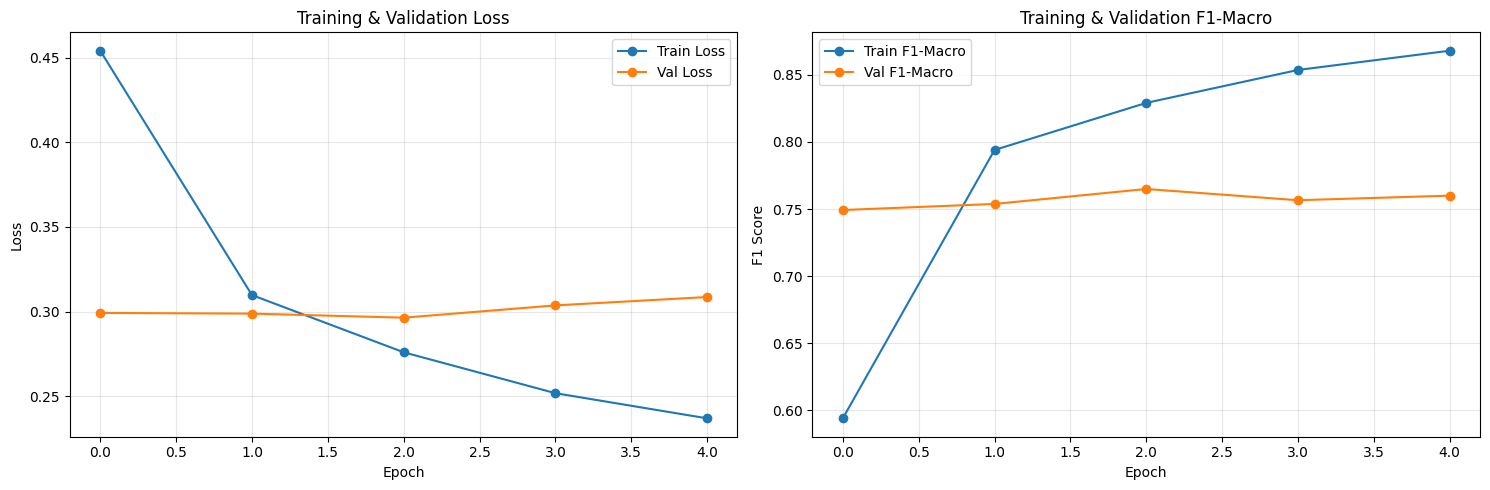

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# F1 plot
axes[1].plot(history['train_f1_macro'], label='Train F1-Macro', marker='o')
axes[1].plot(history['val_f1_macro'], label='Val F1-Macro', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Training & Validation F1-Macro')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300)
plt.show()


**Testing**

Testing on test set
Loaded best model


Testing: 100%|██████████| 109/109 [00:17<00:00,  6.24it/s]



TEST SET RESULTS:
  F1-Micro: 0.8245
  F1-Macro: 0.7558
  Precision: 0.7217
  Recall: 0.7972
  Hamming Loss: 0.0769

PER-CLASS F1 SCORES:
Emotion              F1 Score   Support   
---------------------------------------------
anger                0.7422     654       
fear                 0.7150     91        
joy                  0.9125     2008      
sadness              0.6805     324       
surprise             0.7289     618       

✓ Saved: per_class_performance.png


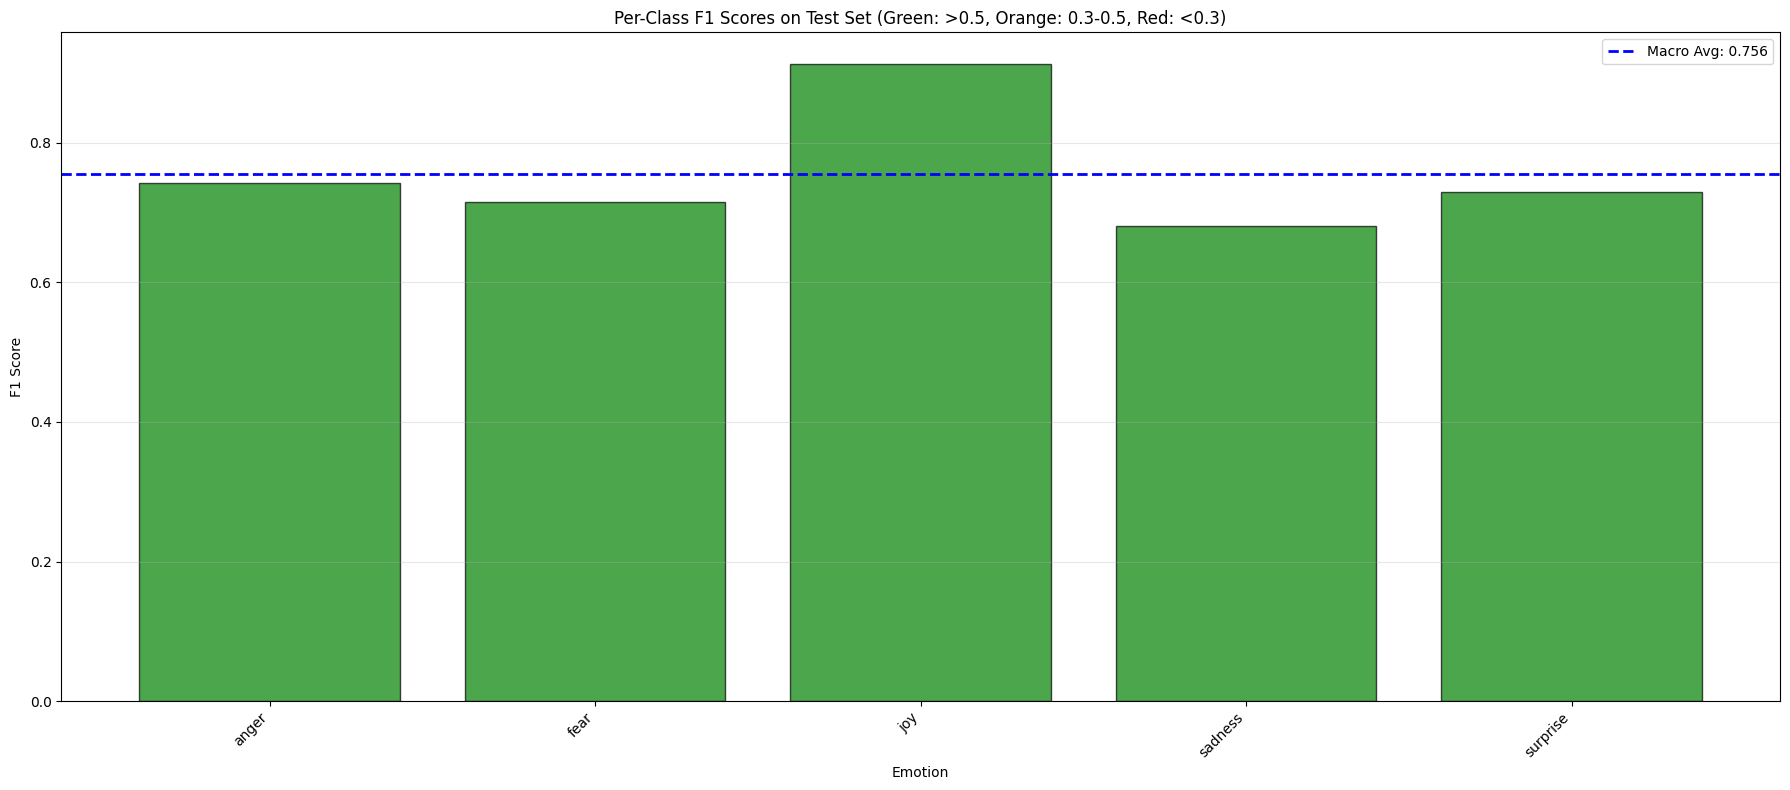

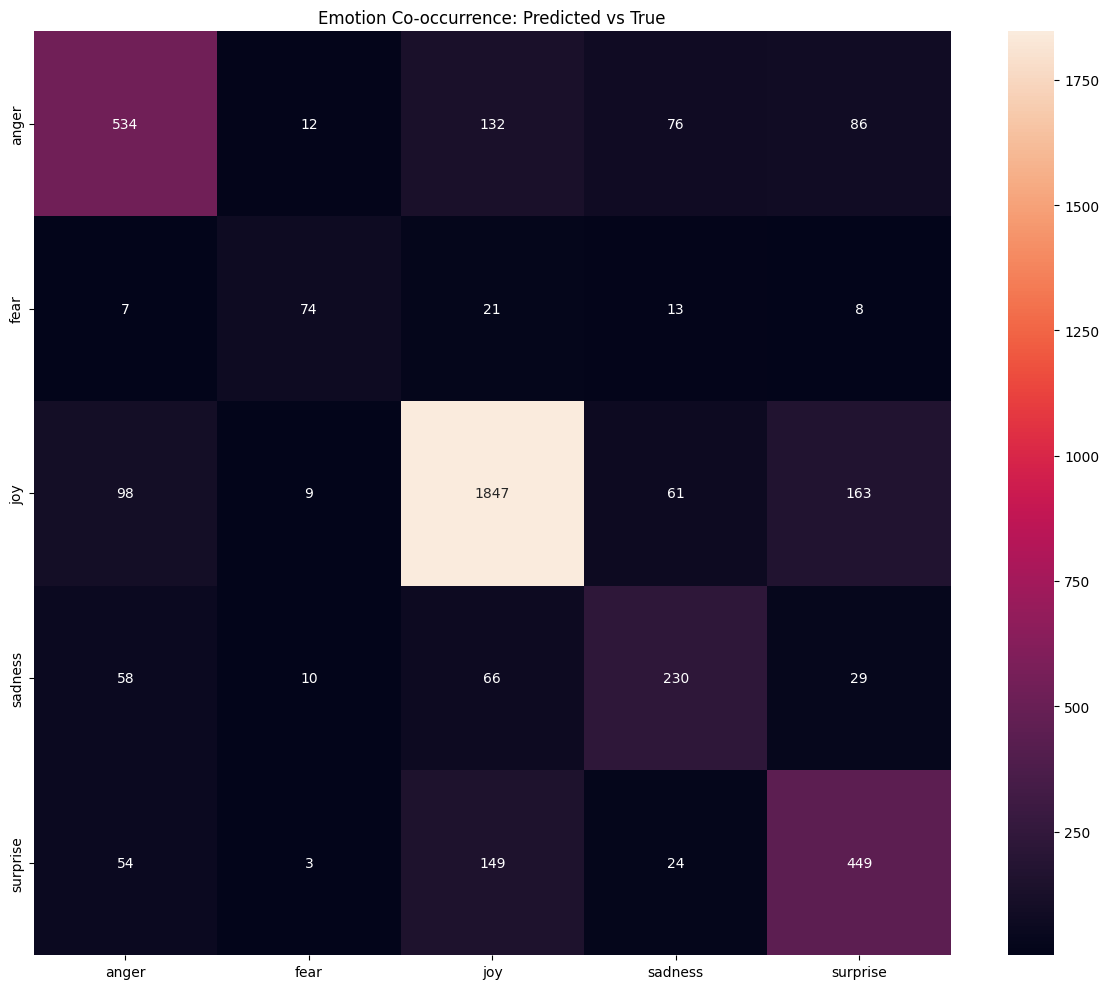

In [18]:

print("Testing on test set")
print("=" * 80)
# Load best model
model.load_state_dict(torch.load(f'{config.MODEL_SAVE_PATH}_best.pt'))
print("Loaded best model")

# Load optimal thresholds
optimal_thresholds = np.load(f'{config.MODEL_SAVE_PATH}_thresholds.npy')

# Get test predictions
model.eval()
test_preds_list = []
test_labels_list = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(config.DEVICE)
        attention_mask = batch['attention_mask'].to(config.DEVICE)
        labels = batch['labels'].to(config.DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.sigmoid(outputs.logits).cpu().numpy()

        test_preds_list.extend(preds)
        test_labels_list.extend(labels.cpu().numpy())

test_preds = np.array(test_preds_list)
test_labels = np.array(test_labels_list)

test_labels_binary = (test_labels > 0.5).astype(int)

# Apply optimized thresholds
test_preds_binary = np.zeros_like(test_preds)
for i in range(config.NUM_LABELS):
    test_preds_binary[:, i] = (test_preds[:, i] >= optimal_thresholds[i]).astype(int)

# Calculate metrics
test_f1_micro = f1_score(test_labels_binary, test_preds_binary, average='micro', zero_division=0)
test_f1_macro = f1_score(test_labels_binary, test_preds_binary, average='macro', zero_division=0)
test_precision = precision_score(test_labels_binary, test_preds_binary, average='macro', zero_division=0)
test_recall = recall_score(test_labels_binary, test_preds_binary, average='macro', zero_division=0)
test_hamming = hamming_loss(test_labels_binary, test_preds_binary)

print(f"\nTEST SET RESULTS:")
print(f"  F1-Micro: {test_f1_micro:.4f}")
print(f"  F1-Macro: {test_f1_macro:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")
print(f"  Hamming Loss: {test_hamming:.4f}")

# Per-class metrics (using optimal thresholds, not 0.5)
# Note: test_preds_binary already uses optimal thresholds from lines 1481-1483
per_class_f1 = f1_score(test_labels_binary, test_preds_binary, average=None, zero_division=0)

print(f"\nPER-CLASS F1 SCORES:")
print(f"{'Emotion':<20} {'F1 Score':<10} {'Support':<10}")
print("-" * 45)
emotion_names = get_emotion_names()
for i, emotion in enumerate(emotion_names):
    support = int(test_labels_binary[:, i].sum())
    print(f"{emotion:<20} {per_class_f1[i]:<10.4f} {support:<10}")

# Visualize per-class performance
emotion_names = get_emotion_names()
plt.figure(figsize=(18, 8))
colors = ['green' if f1 > 0.5 else 'orange' if f1 > 0.3 else 'red' for f1 in per_class_f1]
bars = plt.bar(range(len(emotion_names)), per_class_f1, color=colors, alpha=0.7, edgecolor='black')
plt.xticks(range(len(emotion_names)), emotion_names, rotation=45, ha='right')
plt.xlabel('Emotion')
plt.ylabel('F1 Score')
plt.title('Per-Class F1 Scores on Test Set (Green: >0.5, Orange: 0.3-0.5, Red: <0.3)')
plt.axhline(y=test_f1_macro, color='blue', linestyle='--', linewidth=2, label=f'Macro Avg: {test_f1_macro:.3f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('per_class_performance.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: per_class_performance.png")
plt.show()

# Compute co-occurrence matrix
emotion_names = get_emotion_names()
co_occurrence = np.dot(test_preds_binary.T, test_labels_binary)
plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence, xticklabels=emotion_names,
            yticklabels=emotion_names, annot=True, fmt='g')
plt.title('Emotion Co-occurrence: Predicted vs True')
plt.tight_layout()
plt.savefig('emotion_cooccurrence.png', dpi=300)


In [19]:
def predict_emotions(text, model, tokenizer, device, optimal_thresholds):
    model.eval()

    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=config.MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(outputs.logits).cpu().numpy()[0]

    predictions = []
    for i, prob in enumerate(probs):
        if prob >= optimal_thresholds[i]:
            predictions.append({
                'emotion': config.EKMAN_NAMES[i],
                'probability': float(prob)
            })

    predictions = sorted(predictions, key=lambda x: x['probability'], reverse=True)
    return predictions, probs


print("\n" + "=" * 80)
print("INTERACTIVE EMOTION DETECTION")
print("=" * 80)

optimal_thresholds = np.load(f'{config.MODEL_SAVE_PATH}_thresholds.npy')

# Test
test_sentences = [
    "Everything feels meaningless and exhausting lately",
    "Winning the competition brought an unbelievable sense of joy",
    "The unfair decision made anger boil inside",
    "A strange fear appeared after hearing those footsteps",
    "Tears kept falling without any clear reason",
    "Pride filled the room after years of hard work",
    "The smell in that place was absolutely unbearable",
    "The announcement left everyone in complete shock",
    "Being surrounded by people can still feel incredibly lonely",
    "New opportunities ahead create a strong sense of excitement",
    "Repeating the same mistake again caused deep frustration",
    "A rare moment of peace arrived after weeks of chaos",
    "The silence before the interview felt terrifying",
    "Emptiness replaced all emotions over time",
    "That situation was so unfair it made screaming feel necessary"
]

for i, sentence in enumerate(test_sentences, 1):
    print(f"{i}. Text: \"{sentence}\"")
    predictions, all_probs = predict_emotions(sentence, model, tokenizer, config.DEVICE, optimal_thresholds)

    if predictions:
        print(f"   Detected Emotions:")
        for pred in predictions:
            print(f"     - {pred['emotion']}: {pred['probability']:.3f}")
    else:
        print(f"   No emotions detected")
    print()



INTERACTIVE EMOTION DETECTION
1. Text: "Everything feels meaningless and exhausting lately"
   Detected Emotions:
     - sadness: 0.956

2. Text: "Winning the competition brought an unbelievable sense of joy"
   Detected Emotions:
     - joy: 0.925

3. Text: "The unfair decision made anger boil inside"
   Detected Emotions:
     - anger: 0.948

4. Text: "A strange fear appeared after hearing those footsteps"
   Detected Emotions:
     - fear: 0.975

5. Text: "Tears kept falling without any clear reason"
   Detected Emotions:
     - sadness: 0.892

6. Text: "Pride filled the room after years of hard work"
   Detected Emotions:
     - joy: 0.920

7. Text: "The smell in that place was absolutely unbearable"
   Detected Emotions:
     - anger: 0.855

8. Text: "The announcement left everyone in complete shock"
   Detected Emotions:
     - surprise: 0.943

9. Text: "Being surrounded by people can still feel incredibly lonely"
   Detected Emotions:
     - sadness: 0.957

10. Text: "New oppor

In [20]:
print("\n" + "=" * 80)
print("SAVING MODEL")
print("=" * 80)

# Save model
model.save_pretrained(config.MODEL_SAVE_PATH)
tokenizer.save_pretrained(config.MODEL_SAVE_PATH)

print(f"\nModel saved to: {config.MODEL_SAVE_PATH}")
print(f"Tokenizer saved to: {config.MODEL_SAVE_PATH}")


SAVING MODEL

Model saved to: roberta_emotion_model
Tokenizer saved to: roberta_emotion_model
